# Gradient Visualization for Radial 1D Stellar Wind Simulation

## Imports

In [21]:
# numerics
import jax
import jax.numpy as jnp
import numpy as np
import optax

# timing
from timeit import default_timer as timer

# plotting
import matplotlib.pyplot as plt

# fluids
from jf1uids.boundaries import OPEN_BOUNDARY, REFLECTIVE_BOUNDARY
from jf1uids.geometry import SPHERICAL
from jf1uids.physics_modules.stellar_wind import WindParams
from jf1uids.postprocessing import shock_sensor, strongest_shock_radius
from jf1uids.simulation_config import SimulationConfig
from jf1uids.simulation_helper_data import get_helper_data
from jf1uids.simulation_params import SimulationParams
from jf1uids.time_integration import time_integration
from jf1uids.fluid import primitive_state

# units
from jf1uids.unit_helpers import CodeUnits
from astropy import units as u
import astropy.constants as c
from astropy.constants import m_p

# wind-specific
from weaver import Weaver
from jax import grad

# # 64-bit precision
jax.config.update("jax_enable_x64", True)

# jax.config.update("jax_debug_nans", True)

## Initiating the stellar wind simulation

In [22]:
from jf1uids.geometry import CARTESIAN


print("👷 Setting up simulation...")

# simulation settings
gamma = 5/3

# spatial domain
alpha = SPHERICAL
box_size = 1.0
num_cells = 100
dx = box_size / num_cells

fixed_timestep = False

checkpointing = True
num_checkpoints = 40

# introduce constants to 
# make this more readable
left_boundary = REFLECTIVE_BOUNDARY
right_boundary = OPEN_BOUNDARY

# activate stellar wind
stellar_wind = False

# setup simulation config
config = SimulationConfig(
    alpha_geom = alpha,
    box_size = box_size, 
    num_cells = num_cells,
    left_boundary = left_boundary, 
    right_boundary = right_boundary, 
    stellar_wind = stellar_wind,
    fixed_timestep = fixed_timestep,
    checkpointing = checkpointing,
    num_checkpoints = num_checkpoints
)

helper_data = get_helper_data(config)

👷 Setting up simulation...


## Setting the simulation parameters and initial state

In [23]:

# time domain
dt_max = 0.1
C_CFL = 0.6
t_end = 0.2

# SOD shock tube
shock_pos = 0.5

r = helper_data.geometric_centers

rho = jnp.where(r < shock_pos, 1.0, 0.125)
u = jnp.zeros_like(r)
p = jnp.where(r < shock_pos, 1.0, 0.1)

# get initial state
initial_state = primitive_state(rho, u, p)

params = SimulationParams(C_cfl = C_CFL, dt_max = dt_max, dx = dx, gamma = gamma, t_end = t_end)

## Conservation test of the simulation

In [24]:
from jf1uids.fluid import calculate_total_energy_proxy, calculate_total_mass_proxy


def init_shock_problem(num_cells, config, params, first_order_fallback = False):
    dx = box_size / (num_cells - 1)
    config = config._replace(num_cells = num_cells, first_order_fallback = first_order_fallback)
    params = params._replace(dt_max = dt_max, dx = dx)
    helper_data = get_helper_data(config)
    r = helper_data.geometric_centers
    rho = jnp.where(r < shock_pos, 1.0, 0.125)
    u = jnp.zeros_like(r)
    p = jnp.where(r < shock_pos, 1.0, 0.1)

    # get initial state
    initial_state = primitive_state(rho, u, p)
    return initial_state, config, params, helper_data

def init_acoustics_problem(num_cells, config, params):
    dx = box_size / (num_cells - 1)
    config = config._replace(num_cells = num_cells)
    params = params._replace(dt_max = dt_max, dx = dx)
    helper_data = get_helper_data(config)
    r = helper_data.geometric_centers
    
    # # f = sin^4(pi * r) / r # where 0.4 <= r <= 0.6
    # f = jnp.where((r >= 0.4) & (r <= 0.6), jnp.sin(jnp.pi * ((r - 0.4) / 0.2))**4, 0.0)
    # # f = jnp.sin(jnp.pi * r)**4 / r
    # plt.plot(r, f)
    # epsilon = 1e-4
    rho = 1.5 * jnp.exp(-((r - 0.3) / 0.4)**2) + 1.0 * (1 - jnp.exp(-((r - 0.3) / 0.4)**2))
    u = jnp.ones_like(r)
    p = jnp.zeros_like(r)

    # get initial state
    initial_state = primitive_state(rho, u, p)
    return initial_state, config, params, helper_data

initial_state_shock100, config_shock100, params_shock100, helper_data_shock100 = init_shock_problem(101, config, params)
checkpoints_shock100 = time_integration(initial_state_shock100, config_shock100, params_shock100, helper_data_shock100)
print(params_shock100.dx)
print(helper_data_shock100.geometric_centers[1:] - helper_data_shock100.geometric_centers[:-1])

initial_state_shock100_first_order, config_shock100_first_order, params_shock100_first_order, helper_data_shock100_first_order = init_shock_problem(101, config, params, True)
checkpoints_shock100_first_order = time_integration(initial_state_shock100_first_order, config_shock100_first_order, params_shock100_first_order, helper_data_shock100_first_order)

initial_state_shock, config_shock, params_shock, helper_data_shock = init_shock_problem(2001, config, params, True)
checkpoints_shock2000 = time_integration(initial_state_shock, config_shock, params_shock, helper_data_shock)


0.01
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]


## profiling

In [25]:
# resolutions = [101, 201, 401, 801, 1601, 3201, 6401, 12801]
# runs_per_resolution = 40
# all_runtimes = jnp.zeros((len(resolutions)))
# all_runtimes_per_iteration = jnp.zeros((len(resolutions)))

# for idx, resolution in enumerate(resolutions):
#     print(f"Running resolution {resolution}")
#     runtimes = []
#     runtimes_per_iteration = []
#     for _ in range(runs_per_resolution):
#         initial_state, config, params, helper_data = init_shock_problem(resolution, config, params)
#         checkpoints = time_integration(initial_state, config, params, helper_data)
#         runtimes.append(checkpoints.runtime)
#         runtimes_per_iteration.append(checkpoints.runtime / checkpoints.num_iterations)
#         # print(checkpoints.num_iterations)
#     runtimes = jnp.array(runtimes)
#     runtimes_per_iteration = jnp.array(runtimes_per_iteration)
#     all_runtimes = all_runtimes.at[idx].set(jnp.median(runtimes[5:]))
#     all_runtimes_per_iteration = all_runtimes_per_iteration.at[idx].set(jnp.median(runtimes_per_iteration[5:]))

# print(all_runtimes)
# print(all_runtimes_per_iteration)

### Visualization of the mass and energy development

0.09314633603207767
0.08764137292746454


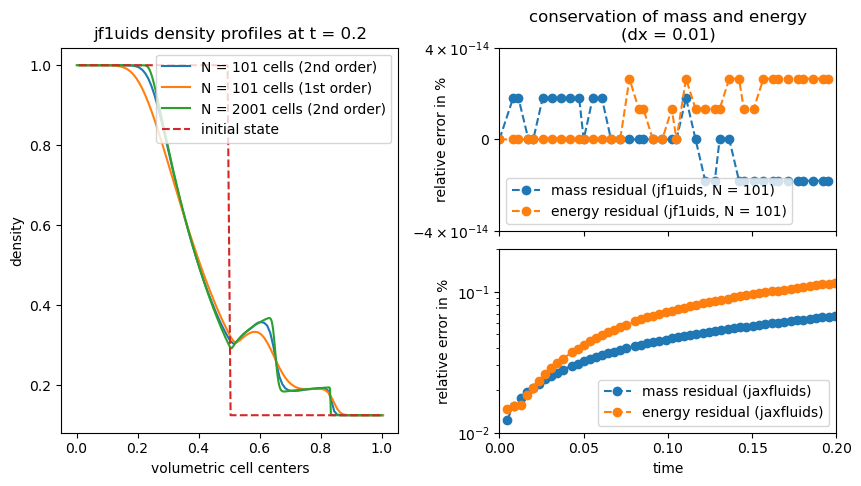

In [26]:
from brokenaxes import brokenaxes
from matplotlib.gridspec import GridSpec

# plot checkpoints_shock.total_mass_proxy and checkpoints_shock.total_energy_proxy over time
relative_mass_error = (checkpoints_shock100.total_mass_proxy - checkpoints_shock100.total_mass_proxy[0]) / checkpoints_shock100.total_mass_proxy[0] * 100
relative_energy_error = (checkpoints_shock100.total_energy_proxy - checkpoints_shock100.total_energy_proxy[0]) / checkpoints_shock100.total_energy_proxy[0] * 100

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(2, 2, figure=fig)

# adapt wspacing
gs.update(wspace=0.3, hspace=0.1)

ax1 = fig.add_subplot(gs[:, 0])  # Left plot spanning both rows
ax2 = fig.add_subplot(gs[0, 1])  # Top-right plot
ax3 = fig.add_subplot(gs[1, 1])  # Bottom-right plot

ax2.plot(checkpoints_shock100.times, relative_mass_error, "o--", label="mass residual (jf1uids, N = 101)")
# ax2.set_xlabel("time")
ax3.set_xlabel("time")
ax2.legend(loc = "upper left")
# ax2 no x numbers but ticks

ax2.set_ylabel("relative error in %")

ax2.yaxis.set_label_coords(-0.15, 0.5)

ax2.plot(checkpoints_shock100.times, relative_energy_error, "o--", label="energy residual (jf1uids, N = 101)")

ax2.legend(loc = "lower left")
ax2.set_title("conservation of mass and energy\n(dx = 0.01)")
ax2.set_xticklabels([])
ax2.set_xlim(0, 0.2)
ax3.set_xlim(0, 0.2)
# less x ticks
ax3.set_xticks([0.0, 0.05, 0.1, 0.15, 0.2])
ax2.set_xticks([0.0, 0.05, 0.1, 0.15, 0.2])

# load sod_error.npy (the jaxfluids errors)
sod_error = jnp.load("sod_errors.npy")
times_jaxfluids, mass_errors_jaxfluids, energy_errors_jaxfluids = sod_error
ax3.plot(times_jaxfluids, mass_errors_jaxfluids, "o--", label="mass residual (jaxfluids)")
ax3.plot(times_jaxfluids, energy_errors_jaxfluids, "o--", label="energy residual (jaxfluids)")
ax3.set_ylim(1e-2, 0.2)

ax3.set_ylabel("relative error in %")

ax3.tick_params(axis='y')

# set y-axis log scale
ax3.set_yscale("log")
ax2.set_yscale("symlog")
ax2.set_ylim(-4e-14, 4e-14)

# ax2.set_xlabel("time")

ax3.legend(loc = "lower right")

# plot the final density at 101 cells first
# and second order and 2004 cells second order
ax1.plot(helper_data_shock100.volumetric_centers, checkpoints_shock100.states[-1,0,:], label="N = 101 cells (2nd order)")
ax1.plot(helper_data_shock100_first_order.volumetric_centers, checkpoints_shock100_first_order.states[-1,0,:], label="N = 101 cells (1st order)")
ax1.plot(helper_data_shock.volumetric_centers, checkpoints_shock2000.states[-1,0,:], label="N = 2001 cells (2nd order)")
# axis title: density profiles at t = 0.15
ax1.set_title("jf1uids density profiles at t = 0.2")

# also plot the initial state in -- for reference
ax1.plot(helper_data_shock100.volumetric_centers, initial_state_shock100[0], "--", label="initial state")

ax1.set_xlabel("volumetric cell centers")
ax1.set_ylabel("density")

ax1.legend(loc = "upper right")

print(checkpoints_shock100.runtime)
print(checkpoints_shock2000.runtime)

# fig.suptitle("spherical shock problem test", y=1.02)

# set figure title
#fig.suptitle("spherical shock problem test")

plt.savefig("shock_problem.pdf", bbox_inches = "tight")

# TODO: ensure same dx

# print(helper_data_shock.volumetric_centers / helper_data_shock.geometric_centers)

In [27]:
# resolutions_to_test = [641, 1281, 2561, 5121, 10241]

# L1_errors = jnp.zeros(len(resolutions_to_test))

# for idx, num_cells in enumerate(resolutions_to_test):

#     print(f"Testing resolution {num_cells}...")

#     initial_state_test, config_test, params_test, helper_data_test = init_acoustics_problem(num_cells, config, params)
#     final_state_test = time_integration(initial_state_test, config_test, params_test, helper_data_test)
    
#     if alpha == 0:
#         r_test = helper_data_test.geometric_centers
#     else:
#         r_test = helper_data_test.volumetric_centers

#     # Find the indices of the closest points in the high-resolution grid (r_best)
#     indices = jnp.searchsorted(r_best, r_test)

#     # Handle edge cases where searchsorted can give an index out of bounds
#     indices = jnp.clip(indices, 0, len(r_best) - 1)

#     # Compute the L1 error comparing low-res values to closest high-res values
#     L1_error = jnp.sqrt((jnp.mean(jnp.abs(final_state_test[0] - final_state_best[0, indices]))) ** 2 + (jnp.mean(jnp.abs(final_state_test[0] - final_state_best[0, indices]))) ** 2 + (jnp.mean(jnp.abs(final_state_test[0] - final_state_best[0, indices]))) ** 2)

#     L1_errors = L1_errors.at[idx].set(L1_error)

# print(L1_errors)

In [28]:
# resolutions_to_test = jnp.array(resolutions_to_test, dtype=jnp.float64)

# plt.loglog(resolutions_to_test, L1_errors, marker='o')

# # fit a line to the log-log data, to estimate the convergence rate
# m, b = np.polyfit(np.log(resolutions_to_test), np.log(L1_errors), 1)
# plt.loglog(resolutions_to_test, np.exp(m * np.log(resolutions_to_test) + b), linestyle='--', label=f"Convergence rate: {m:.2f}")

# plt.xlabel("Number of cells")
# plt.ylabel("L1 error")
# # plt.title("Convergence of Sod shock tube problem")
# plt.legend()

## Visualization

Text(0.5, 1.0, 'Pressure')

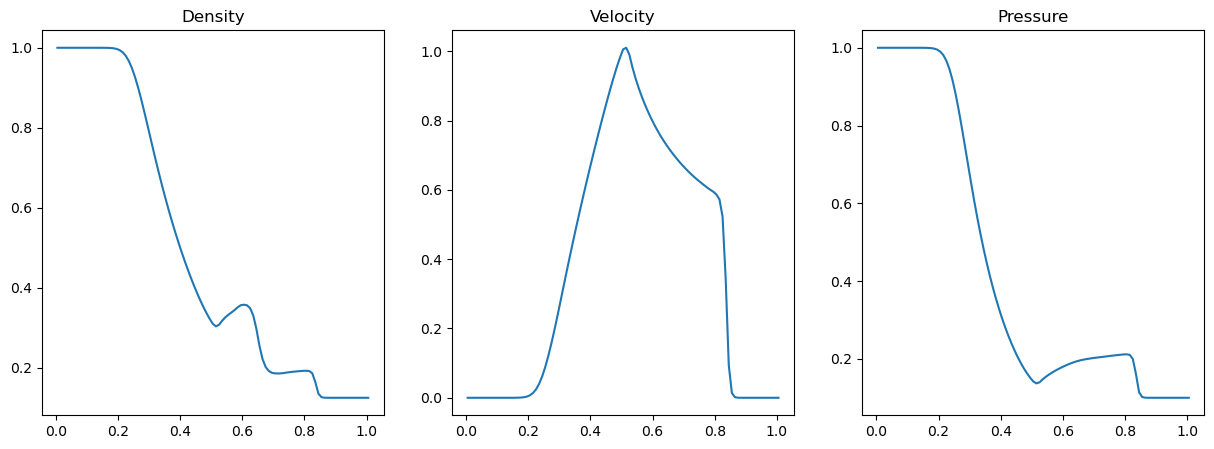

In [29]:
# # initial_state, config, params, helper_data = init_acoustics_problem(100, config, params)

# # final_state = time_integration(initial_state, config, params, helper_data)

rho, u, p = checkpoints_shock100.states[-1]
r = helper_data_shock100.geometric_centers

## plot the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(r, rho)
axs[0].set_title("Density")

axs[1].plot(r, u)
axs[1].set_title("Velocity")

axs[2].plot(r, p)
axs[2].set_title("Pressure")